In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [172]:
df_train=pd.read_csv("train.csv")
df_train.head()

,polar_area,amino_acid_count,isoelectric_point,avg_hydrophobicity,binding_volume,hydrophobic_charge_interaction,protein_mass
0,104.666451,1428,7.367834,0.638777,13.545550,13.588728,497.304337
1,105.783410,247,5.765440,0.746038,13.832919,13.458571,364.149915
2,19.107668,341,6.867458,0.685060,13.629232,54.659498,357.214071
3,68.607075,1096,6.139103,0.724686,21.112143,32.512002,517.509928
4,11.559230,1335,6.806646,0.650576,13.082929,18.815388,805.058707


In [173]:
df_test=pd.read_csv("test.csv")
df_test.head()

,polar_area,amino_acid_count,isoelectric_point,avg_hydrophobicity,binding_volume,hydrophobic_charge_interaction,protein_mass
0,68.356194,651,6.257739,0.657615,6.743080,46.957263,NaN
1,97.566723,622,7.034115,0.597439,20.563718,36.057837,NaN
2,92.171799,670,8.710240,0.446879,17.026363,10.806669,NaN
3,83.057024,950,6.772966,0.441304,15.319411,40.611474,NaN
4,103.983951,1072,6.129048,0.714054,18.504323,44.723059,NaN


In [174]:
df_sub=pd.read_csv("submission.csv")
df_sub.head()

,protein_mass
0,0
1,0
2,0
3,0
4,0


In [175]:
df_train.shape

(14700, 7)

In [176]:
df_test.shape

(300, 7)

In [177]:
# Lets merge these 2 datasets together to simplify to support the data 

In [178]:
combined=pd.concat([df_train,df_test])

In [179]:
combined.head(2)

,polar_area,amino_acid_count,isoelectric_point,avg_hydrophobicity,binding_volume,hydrophobic_charge_interaction,protein_mass
0,104.666451,1428,7.367834,0.638777,13.545550,13.588728,497.304337
1,105.783410,247,5.765440,0.746038,13.832919,13.458571,364.149915


In [180]:
# Lets Explore the Data

# Data Preprocessing

In [182]:
combined.isnull().sum()

polar_area                          0
amino_acid_count                    0
isoelectric_point                   0
avg_hydrophobicity                  0
binding_volume                      0
hydrophobic_charge_interaction      0
protein_mass                      300
dtype: int64

## Outliers treatment

In [184]:
plt.rcParams["figure.figsize"]=[15,10]

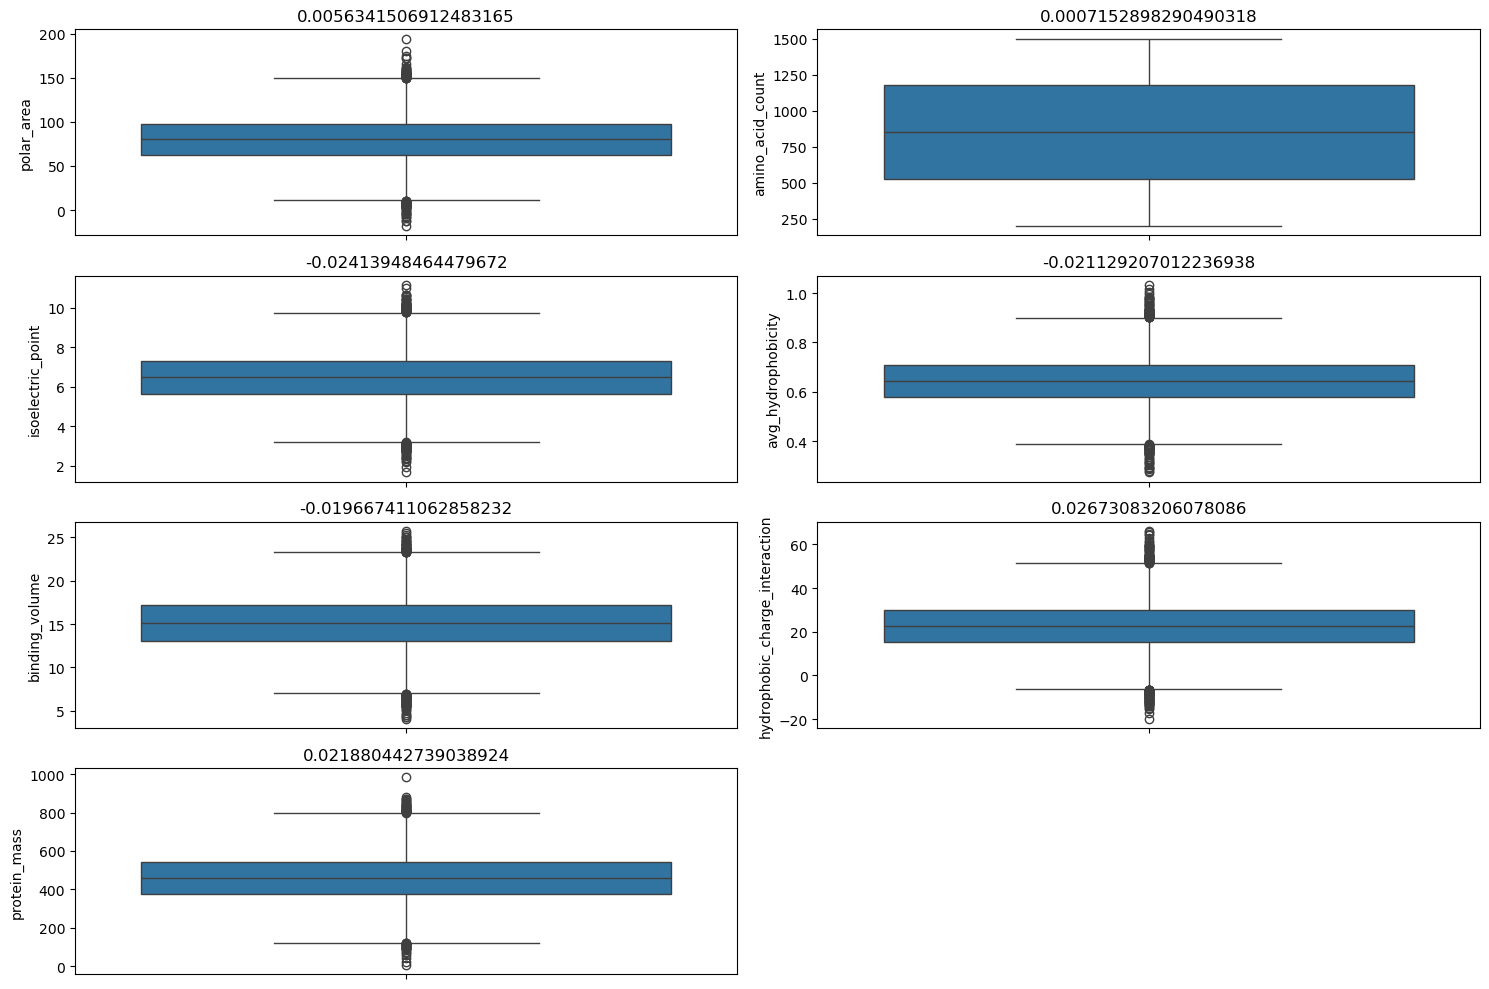

In [185]:
t=1
for i in df_train.columns:
    plt.subplot(4,2,t)
    sns.boxplot(df_train[i])
    plt.title(df_train[i].skew())
    t+=1

plt.tight_layout()
plt.show()

# Univariate Analysis

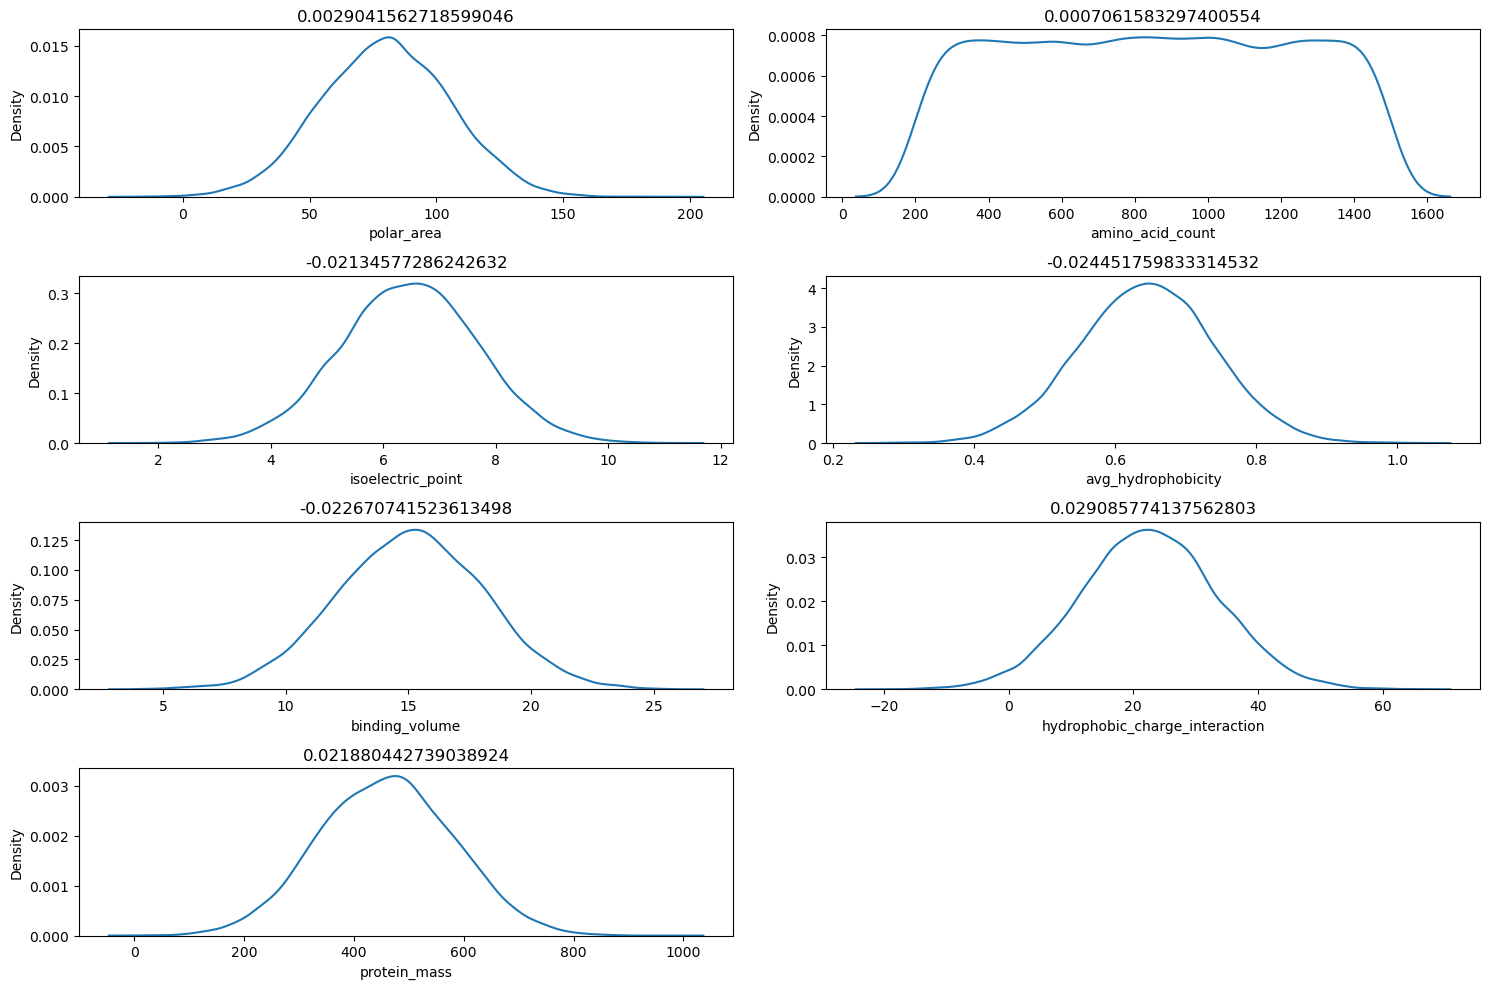

In [187]:
t=1
for i in combined.columns:
    plt.subplot(4,2,t)
    sns.kdeplot(combined[i])
    plt.title(combined[i].skew())
    t+=1

plt.tight_layout()
plt.show()

# Bivariate Analysis

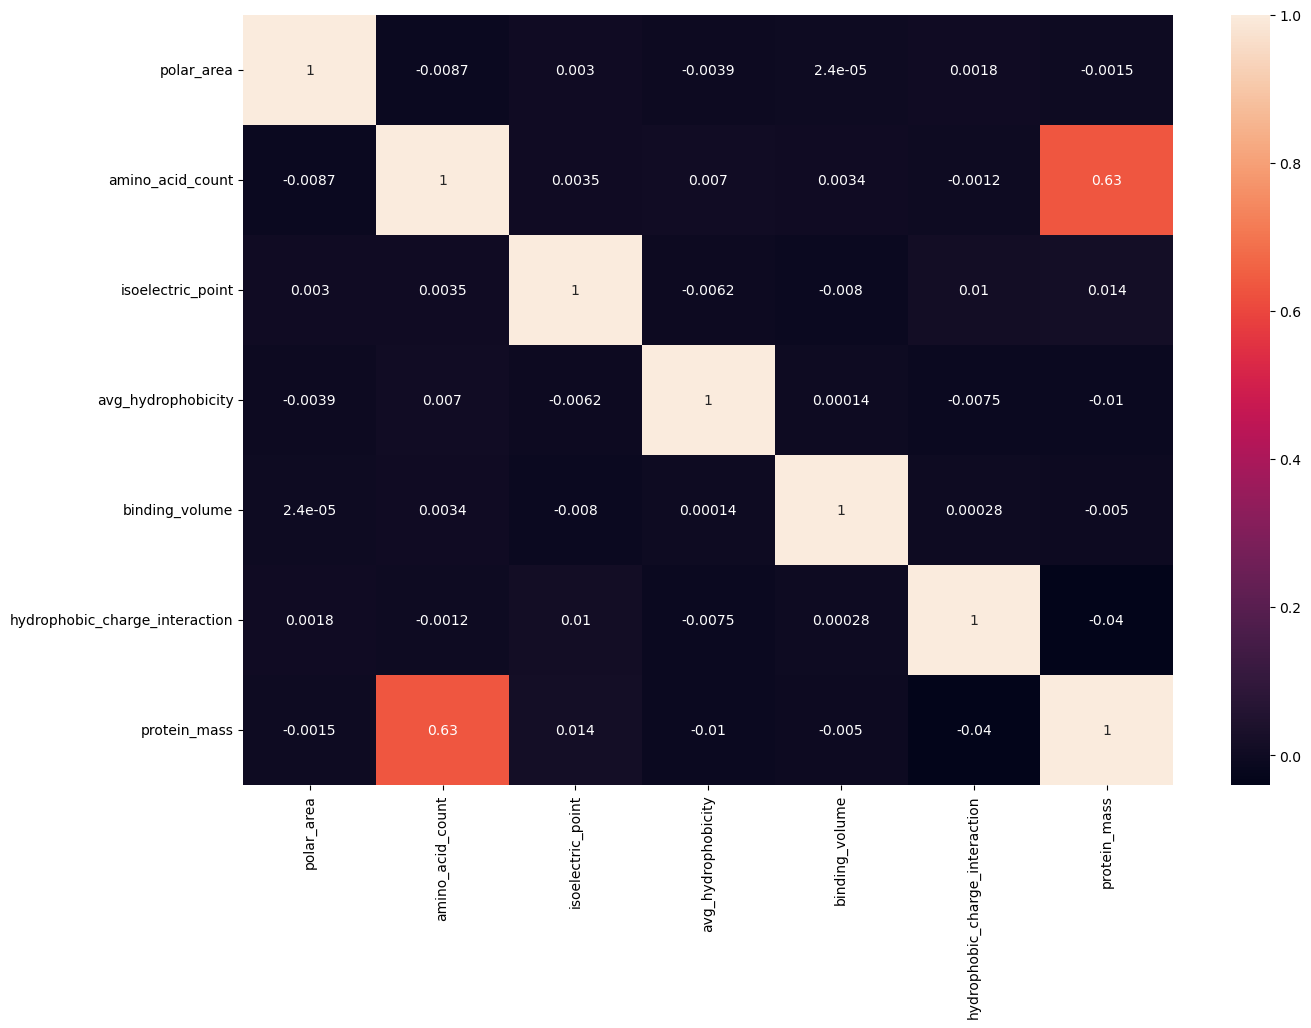

In [189]:
sns.heatmap(combined.corr(),annot=True)
plt.show()

# Predictive Modeling

In [191]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,VotingRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split

In [192]:
x=df_train.drop(columns="protein_mass",axis=1)
y=df_train["protein_mass"]

In [193]:
# Train Test Split

xtrain,xval,ytrain,yval=train_test_split(x,y,random_state=2,train_size=0.80)

In [194]:
xtest=df_test.drop(columns="protein_mass")

In [195]:
xtest.head(2)

,polar_area,amino_acid_count,isoelectric_point,avg_hydrophobicity,binding_volume,hydrophobic_charge_interaction
0,68.356194,651,6.257739,0.657615,6.743080,46.957263
1,97.566723,622,7.034115,0.597439,20.563718,36.057837


In [196]:
print("Training Data: ",xtrain.shape,ytrain.shape)
print("Validation Data: ",xval.shape,yval.shape)
print("Prediction: ",xtest.shape)

Training Data:  (11760, 6) (11760,)
Validation Data:  (2940, 6) (2940,)
Prediction:  (300, 6)


In [197]:
summary=pd.DataFrame(columns=["R2_train","R2_test","RMSE_train","RMSE_test"])
summary.index.name="Model Name"

In [198]:
def metrics(model,yval,ytrain,ypred_train,ypred_test):
    r2_train=r2_score(ytrain,ypred_train)
    r2_test=r2_score(yval,ypred_test)
    RMSE_test=np.sqrt(mean_squared_error(yval,ypred_test))
    RMSE_train=np.sqrt(mean_squared_error(ytrain,ypred_train))

    summary.loc[model]=[r2_train,r2_test,RMSE_train,RMSE_test]
    return summary

# 1. Linear Regression 

In [200]:
model_lr=LinearRegression()
model_lr.fit(xtrain,ytrain)

LinearRegression()

In [201]:
from sklearn.metrics import r2_score,mean_squared_error

In [202]:
model_lr=LinearRegression()
model_lr.fit(xtrain,ytrain)
ypred_test=model_lr.predict(xval)
ypred_train=model_lr.predict(xtrain)

metrics("Linear Regression",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.3902,94.279369,95.477957


# 2. KNN 

In [204]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

In [205]:
xtrain_sc=pd.DataFrame(sc.fit_transform(xtrain),columns=xtrain.columns)
xval_sc=pd.DataFrame(sc.fit_transform(xval),columns=xval.columns)

In [206]:
model_knn=KNeighborsRegressor(n_neighbors=7)
model_knn.fit(xtrain_sc,ytrain)
ypred_test=model_knn.predict(xval_sc)
ypred_train=model_knn.predict(xtrain_sc)
metrics("KNN",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774


# 3. KNN Tuned

In [208]:
from sklearn.model_selection import GridSearchCV

In [209]:
params= {'n_neighbors':[5,6,7],
                   'p': [1,2],
        "weights":["uniform","distance"]}
knn_alg = KNeighborsRegressor()
knn_grid = GridSearchCV(estimator = knn_alg,
                        param_grid = params,
                        cv = 5,
                        scoring ="neg_root_mean_squared_error")

knn_grid.fit(xtrain_sc, ytrain)

print('Best parameters for KNN Regressor: ', knn_grid.best_params_, '\n')

Best parameters for KNN Regressor:  {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} 



In [210]:
model_knn=KNeighborsRegressor(n_neighbors=7,p=1,weights="uniform")
model_knn.fit(xtrain_sc,ytrain)
ypred_test=model_knn.predict(xval_sc)
ypred_train=model_knn.predict(xtrain_sc)
metrics("KNN-TUNED",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031


# Decision Tree

In [212]:
model_dt=DecisionTreeRegressor(max_depth=5)
model_dt.fit(xtrain_sc,ytrain)

DecisionTreeRegressor(max_depth=5)

In [213]:
model_dt=DecisionTreeRegressor(max_depth=5)
model_dt.fit(xtrain_sc,ytrain)
ypred_test=model_dt.predict(xval_sc)
ypred_train=model_dt.predict(xtrain_sc)

metrics("Decision_Tree",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754


# Decision Tree- Tuned

In [215]:
from sklearn.model_selection import GridSearchCV

In [216]:
params= {'max_depth':[3,5,6,7],
        'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4]}

dt_alg = DecisionTreeRegressor()
dt_grid = GridSearchCV(estimator = dt_alg,
                        param_grid = params,
                        cv = 5,
                        scoring ="neg_root_mean_squared_error")

dt_grid.fit(xtrain_sc, ytrain)

print('Best parameters for DT-R: ',dt_grid.best_params_, '\n')

Best parameters for DT-R:  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} 



In [217]:
model_fdt=DecisionTreeRegressor(max_depth=3, min_samples_leaf=4, min_samples_split= 5)
model_fdt.fit(xtrain_sc,ytrain)
ypred_test=model_fdt.predict(xval_sc)
ypred_train=model_fdt.predict(xtrain_sc)

metrics("Decision_Tree-TUNED",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739


# RandomForestRegressor

In [219]:
rfc = RandomForestRegressor(random_state=6)
rfc.fit(xtrain_sc, ytrain)
ypred_test = rfc.predict(xval_sc)
ypred_train=rfc.predict(xtrain_sc)

metrics("RandomForestRegressor",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907


# RandomForest Tuned

In [221]:
params= {"n_estimators": [50,60],
        'max_depth': [3,5]}

rfc_alg = RandomForestRegressor()
rfc_grid = GridSearchCV(estimator = rfc_alg,
                        param_grid = params,
                        cv = 5,
                        scoring ="neg_root_mean_squared_error")

rfc_grid.fit(xtrain_sc, ytrain)

print('Best parameters for RF Regressor: ', rfc_grid.best_params_, '\n')

Best parameters for RF Regressor:  {'max_depth': 3, 'n_estimators': 50} 



In [222]:
rfct = RandomForestRegressor(max_depth=3, n_estimators= 60,random_state=6)
rfct.fit(xtrain_sc, ytrain)
ypred_test = rfct.predict(xval_sc)
ypred_train=rfct.predict(xtrain_sc)

metrics("RandomForestRegressor-Tuned",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081


# XGboost

In [224]:
model_xg=XGBRegressor(n_estimators=100,gamma=7)
model_xg.fit(xtrain_sc,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=7, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [225]:
model_xg=XGBRegressor(n_estimators=100,gamma=7)
model_xg.fit(xtrain_sc,ytrain)
ypred_test=model_xg.predict(xval_sc)
ypred_train=model_xg.predict(xtrain_sc)

metrics("XGBoost",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081
XGBoost,0.730956,0.317026,63.451097,101.044279


# Fine Tune the XGB

In [227]:
from sklearn.model_selection import GridSearchCV

In [228]:
grid={"n_estimators":[40,50,60,75],
     "max_depth":[3,4,5,6],
     "reg_alpha":[6,7,9]}
gscv=GridSearchCV(estimator=XGBRegressor()
                  ,param_grid=grid,
                  cv=5,scoring="neg_root_mean_squared_error")

gscv.fit(xtrain,ytrain)

print('Best parameters for XGBoost Regressor: ', gscv.best_params_, '\n')

Best parameters for XGBoost Regressor:  {'max_depth': 3, 'n_estimators': 40, 'reg_alpha': 9} 



In [229]:
model_xgb=XGBRegressor(**gscv.best_params_)
model_xgb.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=40,
             n_jobs=None, num_parallel_tree=None, ...)

In [230]:
model_xgb=XGBRegressor(**gscv.best_params_)
model_xgb.fit(xtrain_sc,ytrain)
ypred_test=model_xgb.predict(xval_sc)
ypred_train=model_xgb.predict(xtrain_sc)

metrics("XGBoost-Tuned",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081
XGBoost,0.730956,0.317026,63.451097,101.044279
XGBoost-Tuned,0.436829,0.379327,91.801014,96.325433


# Adaboost

In [232]:
from sklearn.ensemble import AdaBoostRegressor

In [233]:
adb = AdaBoostRegressor(random_state=10)
adb.fit(xtrain_sc, ytrain)
ypred_test=adb.predict(xval_sc)
ypred_train=adb.predict(xtrain_sc)

metrics("AdaBoost",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081
XGBoost,0.730956,0.317026,63.451097,101.044279
XGBoost-Tuned,0.436829,0.379327,91.801014,96.325433


In [234]:
# Adaboost Tuned

In [235]:
grid={"n_estimators":[40,50,60],
     "learning_rate": [0.1,0.2,0.3]}
adab=GridSearchCV(estimator=AdaBoostRegressor()
                  ,param_grid=grid,
                  cv=5,scoring="neg_root_mean_squared_error")

adab.fit(xtrain_sc,ytrain)

print('Best parameters for XGBoost Regressor: ', adab.best_params_, '\n')

Best parameters for XGBoost Regressor:  {'learning_rate': 0.1, 'n_estimators': 40} 



In [236]:
adbf = AdaBoostRegressor(**adab.best_params_)
adbf.fit(xtrain_sc, ytrain)
ypred_test=adbf.predict(xval_sc)
ypred_train=adbf.predict(xtrain_sc)

metrics("AdaBoost-TUNED",yval,ytrain,ypred_train,ypred_test)

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081
XGBoost,0.730956,0.317026,63.451097,101.044279
XGBoost-Tuned,0.436829,0.379327,91.801014,96.325433


# Submission

In [129]:
summary

,R2_train,R2_test,RMSE_train,RMSE_test
Model Name,,,,
Linear Regression,0.406011,0.390200,94.279369,95.477957
KNN,0.486839,0.292139,87.630328,102.868774
KNN-TUNED,0.488241,0.302051,87.510470,102.146031
Decision_Tree,0.415588,0.379709,93.516242,96.295754
Decision_Tree-TUNED,0.404326,0.382309,94.412971,96.093739
RandomForestRegressor,0.912314,0.356025,36.223767,98.116907
RandomForestRegressor-Tuned,0.406949,0.384078,94.204918,95.956081
XGBoost,0.730956,0.317026,63.451097,101.044279
XGBoost-Tuned,0.436829,0.379327,91.801014,96.325433


In [297]:
xtest=pd.DataFrame(sc.fit_transform(xtest),columns=xtest.columns,index=xtest.index)

In [299]:
rfct = RandomForestRegressor(max_depth=3, n_estimators= 60,random_state=6)
rfct.fit(xtrain_sc, ytrain)
pred=rfct.predict(xtest)

In [301]:
xtest

,polar_area,amino_acid_count,isoelectric_point,avg_hydrophobicity,binding_volume,hydrophobic_charge_interaction
0,-0.473712,-0.544478,-0.230469,0.161500,-2.617817,2.263883
1,0.701902,-0.619947,0.392816,-0.446497,1.886466,1.250660
2,0.484776,-0.495033,1.738431,-1.967704,0.733607,-1.096716
3,0.117941,0.233633,0.183162,-2.024032,0.177294,1.673972
4,0.960171,0.551123,-0.333783,0.731741,1.215289,2.056189
...,...,...,...,...,...,...
295,0.551056,0.522497,0.663908,-1.108792,0.694153,0.431665
296,-1.071936,1.035166,-1.886507,-0.901748,-0.309889,1.388397
297,-0.734467,0.936275,0.176897,-0.996874,-2.841585,1.876586
298,1.408822,1.022154,-1.715986,0.521585,-1.263819,-1.804757


In [303]:
df_sub["protein_mass"]=pred

In [305]:
pred

array([408.75496833, 407.01043033, 413.26983037, 480.84785226,
       494.65905763, 493.03283987, 413.26983037, 511.76534456,
       511.76534456, 472.72611063, 441.30467122, 550.79665828,
       404.04740517, 392.23941336, 371.72003759, 370.89340605,
       451.24143626, 543.58773241, 492.62844282, 376.13117145,
       579.78254493, 493.03283987, 370.89340605, 492.62844282,
       370.89340605, 459.29291188, 407.57207993, 544.65392862,
       550.23251878, 377.227304  , 333.90848708, 408.17367076,
       333.90848708, 402.02885137, 477.90811735, 579.78254493,
       403.05429924, 407.01043033, 551.40387864, 581.42785105,
       403.05429924, 480.84785226, 333.90848708, 442.57840309,
       402.02885137, 581.42785105, 402.02885137, 487.41203164,
       544.65392862, 442.00154181, 410.5688047 , 487.41203164,
       333.90848708, 333.90848708, 440.81662403, 579.78254493,
       511.76534456, 440.24584328, 493.03283987, 418.12728805,
       377.227304  , 333.90848708, 459.69730892, 581.42

In [307]:
df_sub.to_csv("Final_Submission.csv",index=False)